In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext lab_black

## Explore a base model that only uses microdensities to determine the next microdensity.
Thus, to increase our data:  
- We have 39 instances per county
- We can use the first 23 to calculate the 24, then 2-25 to calculate 26, and so on.
- We then have trained a model that can predict the next microdensity based on previous instances.

- As a later stage we can include census information as an extra filtering technique

In [2]:
df = pd.read_csv(
    "../data/processed/county_data.csv",
    usecols=[
        "cfips",
        "first_day_of_month",
        "active",
        "POPESTIMATE2021",
        "microbusiness_density",
    ],
)
test = pd.read_csv("../data/raw/test.csv")

In [3]:
df.head()

,cfips,first_day_of_month,microbusiness_density,active,POPESTIMATE2021
0,1001,2019-08-01,3.007682,1249,59095
1,1001,2019-09-01,2.884870,1198,59095
2,1001,2019-10-01,3.055843,1269,59095
3,1001,2019-11-01,2.993233,1243,59095
4,1001,2019-12-01,2.993233,1243,59095


In [4]:
df["cfips"].value_counts()

1001     39
39133    39
39089    39
39091    39
39093    39
         ..
21113    39
21115    39
21117    39
21119    39
56045    39
Name: cfips, Length: 3135, dtype: int64

### Create the timeseries

In [5]:
# Create an empty list to store the new time series
time_series = []

# Loop over each cfips
for cfips in df["cfips"].unique():
    # Filter the data for the current cfips
    df_cfips = df[df["cfips"] == cfips].reset_index(drop=True)
    # Loop over the time series from 0 to 14 (inclusive)
    for i in range(0, 15):
        # Create a new time series with the values for the current cfips and range of first_day_of_month
        time_series.append(
            {
                "cfips": cfips,
                "POPESTIMATE2021": df_cfips.loc[0, "POPESTIMATE2021"],
                "active": df_cfips.loc[0, "active"],
                "microbusiness_density": df_cfips.loc[
                    i : i + 23, "microbusiness_density"
                ].values.tolist(),
                "target": df_cfips.loc[i + 24, "microbusiness_density"],
                "target_date": df_cfips.loc[i + 24, "first_day_of_month"],
            }
        )

# Create a new dataframe with the list of time series
new_df = pd.DataFrame(time_series)

In [6]:
new_df.head()

,cfips,POPESTIMATE2021,active,microbusiness_density,target,target_date
0,1001,59095,1249,"[3.0076818, 2.8848701, 3.0558431, 2.9932332, 2...",3.219917,2021-08-01
1,1001,59095,1249,"[2.8848701, 3.0558431, 2.9932332, 2.9932332, 2...",3.186722,2021-09-01
2,1001,59095,1249,"[3.0558431, 2.9932332, 2.9932332, 2.96909, 2.9...",3.203320,2021-10-01
3,1001,59095,1249,"[2.9932332, 2.9932332, 2.96909, 2.9093256, 2.9...",3.200948,2021-11-01
4,1001,59095,1249,"[2.9932332, 2.96909, 2.9093256, 2.9332314, 3.0...",3.286307,2021-12-01


### Make it a dataframe

In [7]:
# convert the list of microbusiness_density to a numpy array and then each into a column
new_df["microbusiness_density"] = new_df["microbusiness_density"].apply(
    lambda x: np.array(x)
)
new_df = pd.concat(
    [
        new_df.drop(["microbusiness_density"], axis=1),
        new_df["microbusiness_density"].apply(pd.Series),
    ],
    axis=1,
)
new_df.head()

,cfips,POPESTIMATE2021,active,target,target_date,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,1001,59095,1249,3.219917,2021-08-01,3.007682,2.884870,3.055843,2.993233,2.993233,...,3.193804,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433
1,1001,59095,1249,3.186722,2021-09-01,2.884870,3.055843,2.993233,2.993233,2.969090,...,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917
2,1001,59095,1249,3.203320,2021-10-01,3.055843,2.993233,2.993233,2.969090,2.909326,...,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722
3,1001,59095,1249,3.200948,2021-11-01,2.993233,2.993233,2.969090,2.909326,2.933231,...,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320
4,1001,59095,1249,3.286307,2021-12-01,2.993233,2.969090,2.909326,2.933231,3.000167,...,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948


In [8]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47025 entries, 0 to 47024
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cfips            47025 non-null  int64  
 1   POPESTIMATE2021  47025 non-null  int64  
 2   active           47025 non-null  int64  
 3   target           47025 non-null  float64
 4   target_date      47025 non-null  object 
 5   0                47025 non-null  float64
 6   1                47025 non-null  float64
 7   2                47025 non-null  float64
 8   3                47025 non-null  float64
 9   4                47025 non-null  float64
 10  5                47025 non-null  float64
 11  6                47025 non-null  float64
 12  7                47025 non-null  float64
 13  8                47025 non-null  float64
 14  9                47025 non-null  float64
 15  10               47025 non-null  float64
 16  11               47025 non-null  float64
 17  12          

### Persist

In [9]:
new_df.to_csv("../data/processed/timeseries_15_rows_per_county.csv", index=False)

## Machine Learning

In [10]:
test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])
test.sort_values(["cfips", "first_day_of_month"], inplace=True)

In [11]:
ids = df["cfips"].unique()
# create X, which is df_new without the target column
X = new_df.drop(["target", "target_date", "cfips", "POPESTIMATE2021", "active"], axis=1)
y = new_df["target"]
grps = new_df["cfips"]
threshold = 0.1

In [12]:
# import group kfold
from sklearn.model_selection import GroupKFold

# import xgboost predictor
from xgboost import XGBRegressor

### Kfold groups for validating results on XGboost

In [13]:
# create a group kfold object
group_kfold = GroupKFold(n_splits=5)
print(X.shape, y.shape, ids.shape)
models_scores = {}
# split the data and targets
for split, (train_index, valid_index) in enumerate(
    group_kfold.split(X, y, groups=grps)
):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    print(f"Split {split}:")
    # predict with xgboost
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)
    # calculate the mean absolute error
    mae = np.mean(np.abs(y_pred - y_valid))
    print(f"MAE: {mae}")
    # calculate sMAPE
    smape = np.mean(np.abs(y_pred - y_valid) / (np.abs(y_pred) + np.abs(y_valid)))
    print(f"sMAPE: {smape}")
    # calculate the percentage of predictions that are within the  threshold

    pct_within_threshold = np.mean((smape) <= threshold) * 100
    print(f"Percentage within threshold: {pct_within_threshold}")
    models_scores[split] = mae

(47025, 24) (47025,) (3135,)
Split 0:
MAE: 0.07740397118491128
sMAPE: 0.010581203752371999
Percentage within threshold: 100.0
Split 1:
MAE: 0.0975061128612925
sMAPE: 0.010047461684322719
Percentage within threshold: 100.0
Split 2:
MAE: 0.05726510986975953
sMAPE: 0.0087648453450335
Percentage within threshold: 100.0
Split 3:
MAE: 0.2303507163601739
sMAPE: 0.009217441227716287
Percentage within threshold: 100.0
Split 4:
MAE: 0.1018192655202886
sMAPE: 0.009305789961641941
Percentage within threshold: 100.0


### Results Kfold

In [14]:
models_scores

{0: 0.07740397118491128,
 1: 0.0975061128612925,
 2: 0.05726510986975953,
 3: 0.2303507163601739,
 4: 0.1018192655202886}

### Train whole dataset XGboosting

In [15]:
# train model on whole dataset
xgb = XGBRegressor()
xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [16]:
ids = test["cfips"].unique()
predictions = np.zeros((len(ids), 8))
test_df = new_df[new_df["target_date"] == new_df["target_date"].max()].drop(
    ["target_date", "POPESTIMATE2021", "active", "cfips"], axis=1
)

In [17]:
test_df[24] = test_df["target"]
test_df.drop(["target", 0], axis=1, inplace=True)
test_df.columns = range(0, 24)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
14,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,...,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856
29,8.263252,8.224466,8.011045,7.909001,7.978031,8.032654,8.061466,8.077073,7.984033,7.918605,...,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701,8.359798
44,1.032144,1.032144,1.111998,1.072105,1.057146,1.102025,1.097038,1.107011,1.146903,1.156876,...,1.186629,1.206827,1.196728,1.191678,1.186629,1.191678,1.216926,1.196728,1.206827,1.232074
59,1.320797,1.309604,1.310044,1.287650,1.287650,1.259657,1.259657,1.237263,1.237263,1.209271,...,1.214165,1.236650,1.264755,1.253513,1.247892,1.275998,1.326588,1.292861,1.315346,1.287240
74,1.641125,1.613962,1.612029,1.688793,1.700081,1.702339,1.720401,1.713628,1.715885,1.711370,...,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060,1.831783


### Predictions

In [18]:
# loop over the dataset and make predictions adding the last prediction as input for the next point
for i in range(8):
    predictions[:, i] = xgb.predict(test_df)
    # print(test_df.iloc[1, :])
    test_df[i + 24] = predictions[:, i]
    test_df.drop(0, axis=1, inplace=True)
    # rename the columns to 0:23
    test_df.columns = range(0, 24)
    # print(test_df.iloc[1, :])

In [19]:
predictions.reshape(-1).shape

(25080,)

### Submission file

In [20]:
# submission = test_df[:, -8:]
test["microbusiness_density"] = predictions.reshape(-1)

In [21]:
test.head(8)

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.436547
3135,1001_2022-12-01,1001,2022-12-01,3.430106
6270,1001_2023-01-01,1001,2023-01-01,3.430106
9405,1001_2023-02-01,1001,2023-02-01,3.430106
12540,1001_2023-03-01,1001,2023-03-01,3.430106
15675,1001_2023-04-01,1001,2023-04-01,3.431787
18810,1001_2023-05-01,1001,2023-05-01,3.431787
21945,1001_2023-06-01,1001,2023-06-01,3.431787


In [22]:
result = test[["row_id", "microbusiness_density"]]
result.to_csv("../data/submissions/ml_test_1.csv", index=False)

## Plot stuff

In [23]:
train_df = pd.read_csv("../data/raw/train.csv")

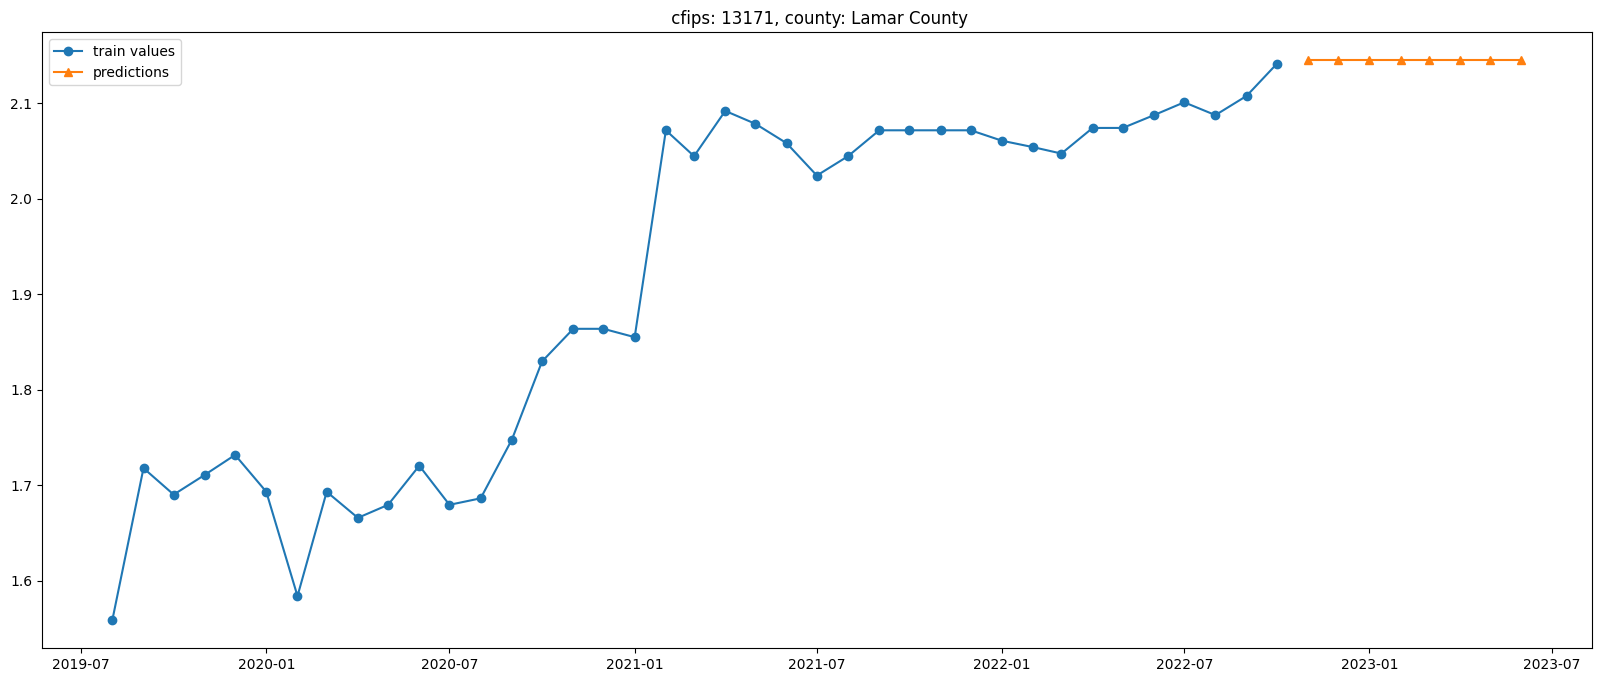

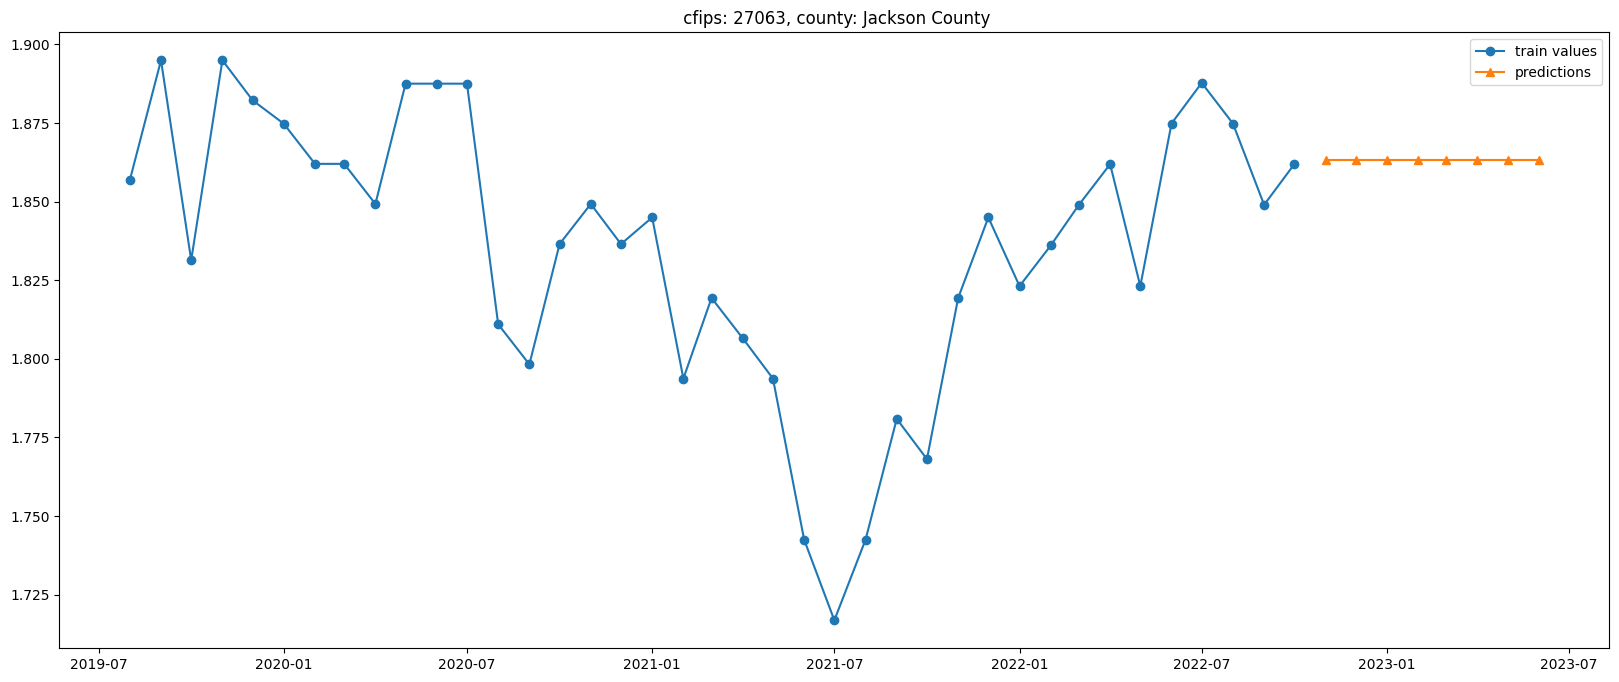

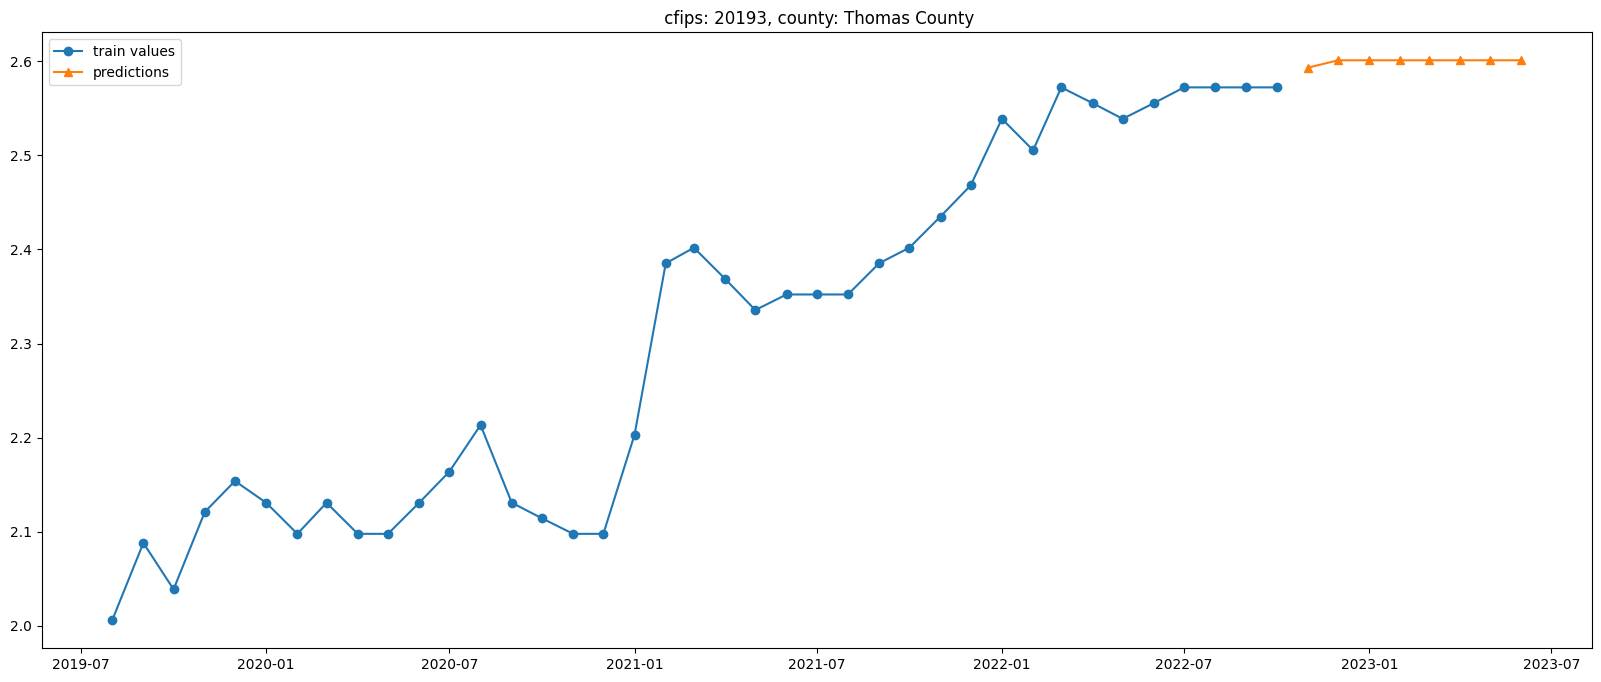

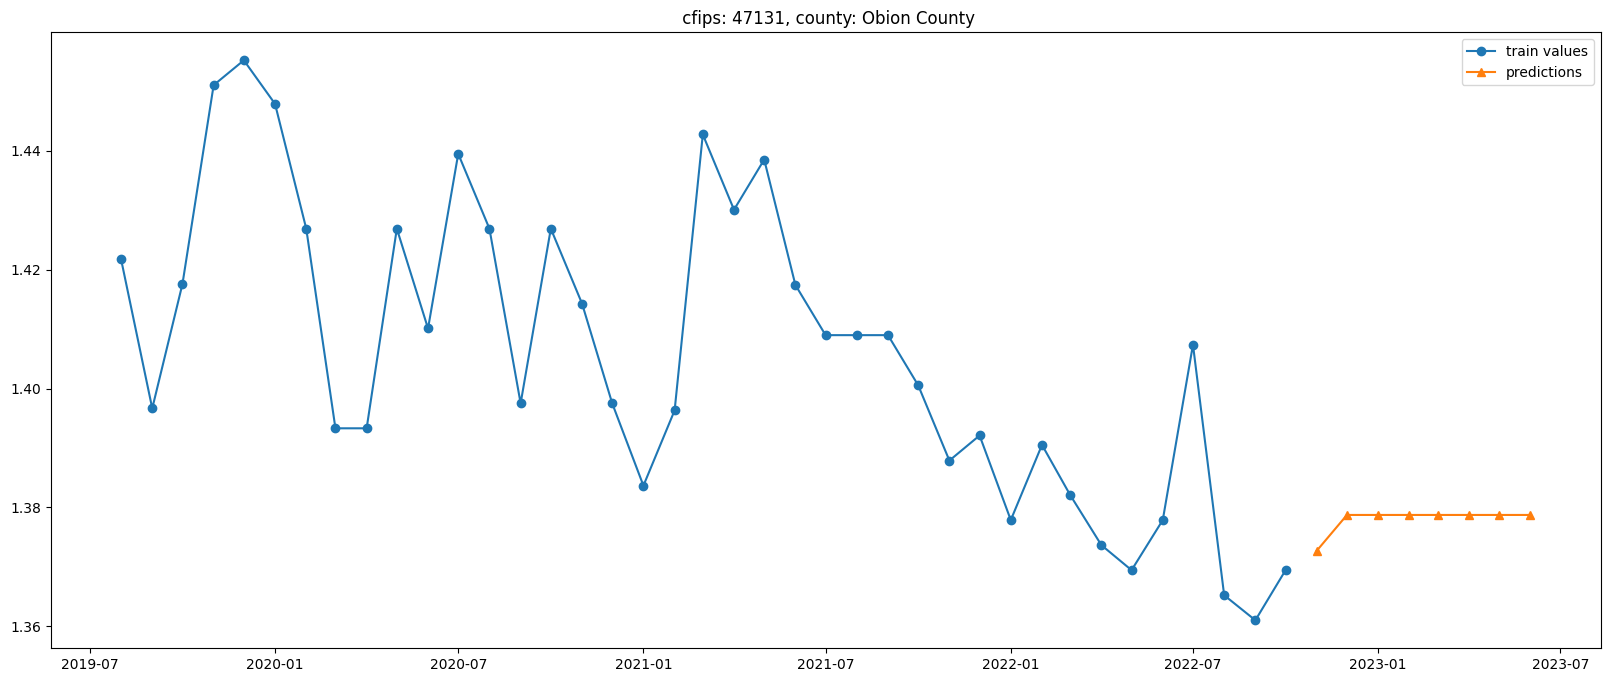

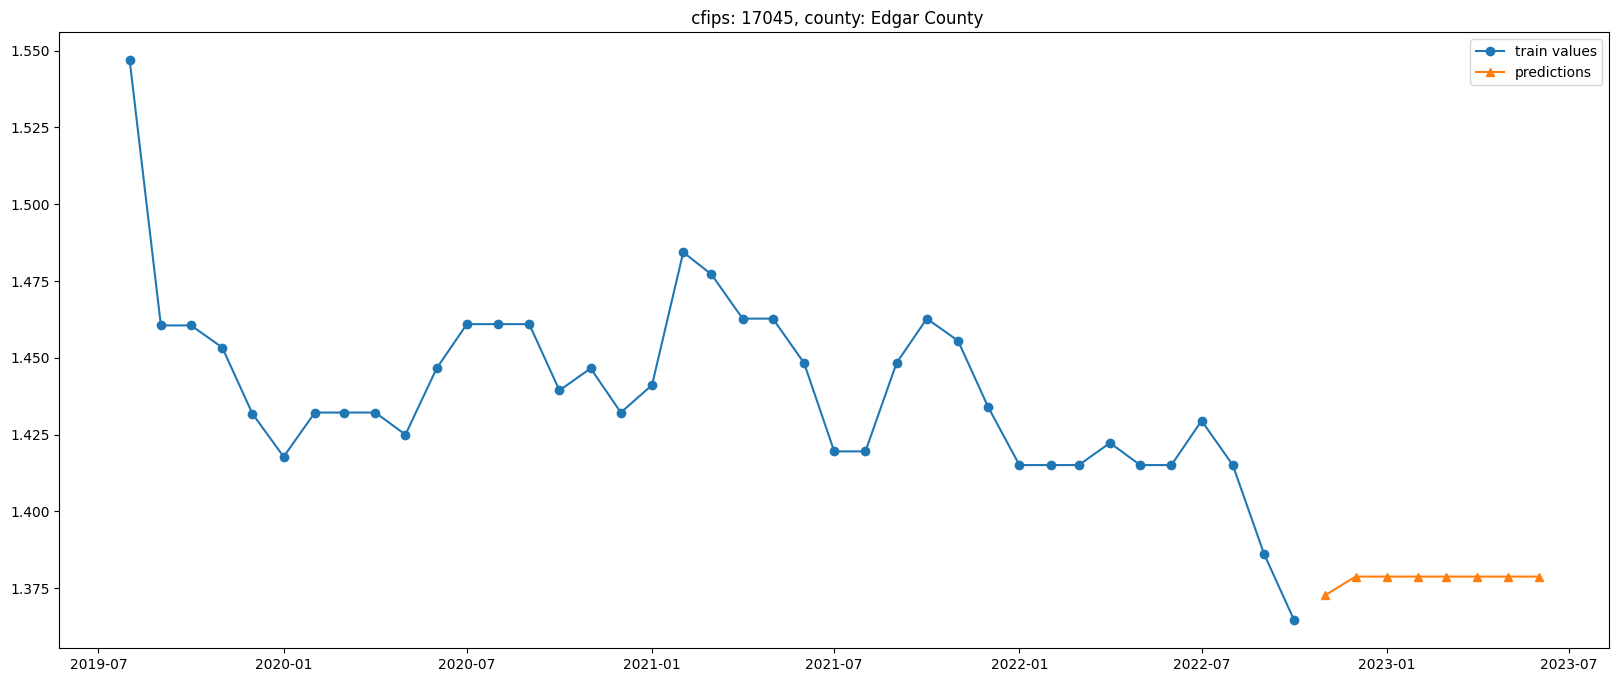

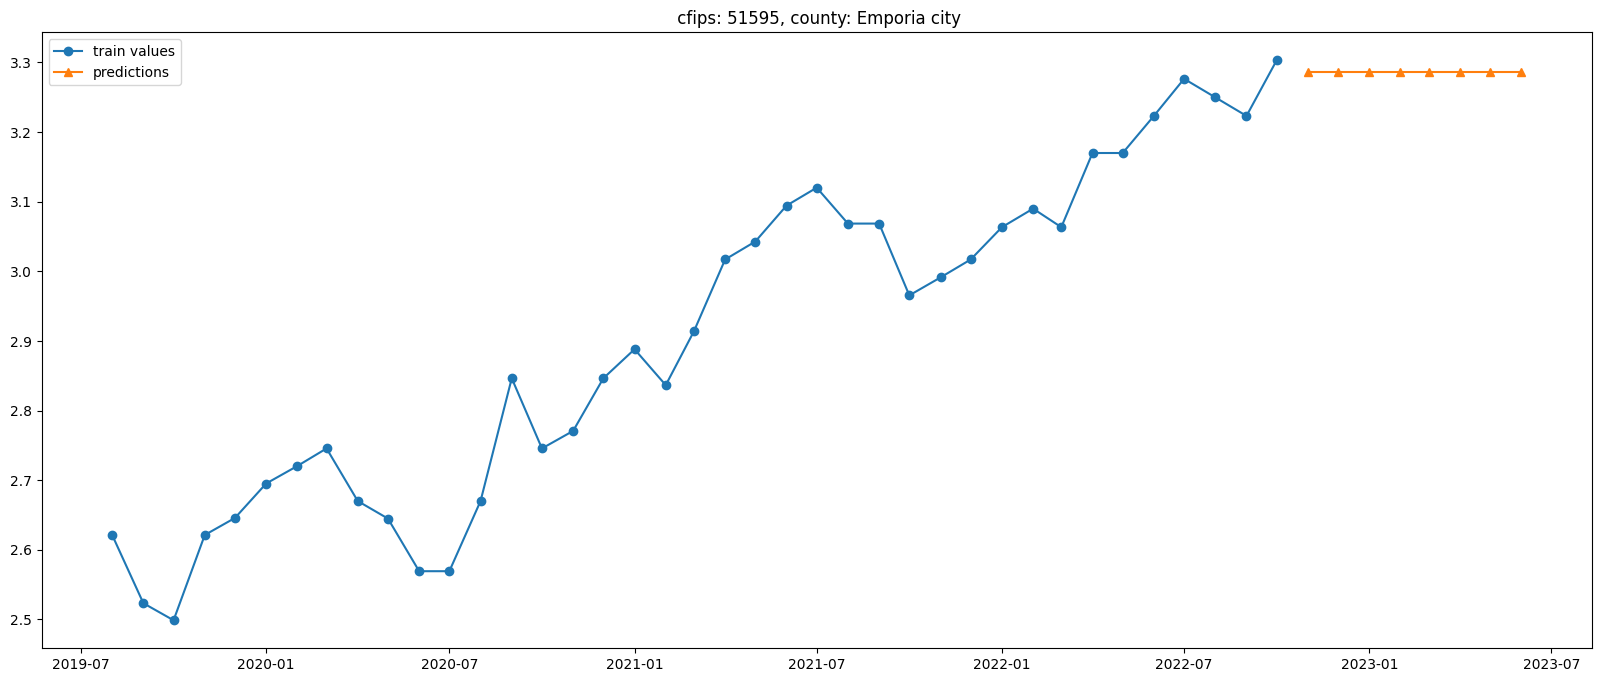

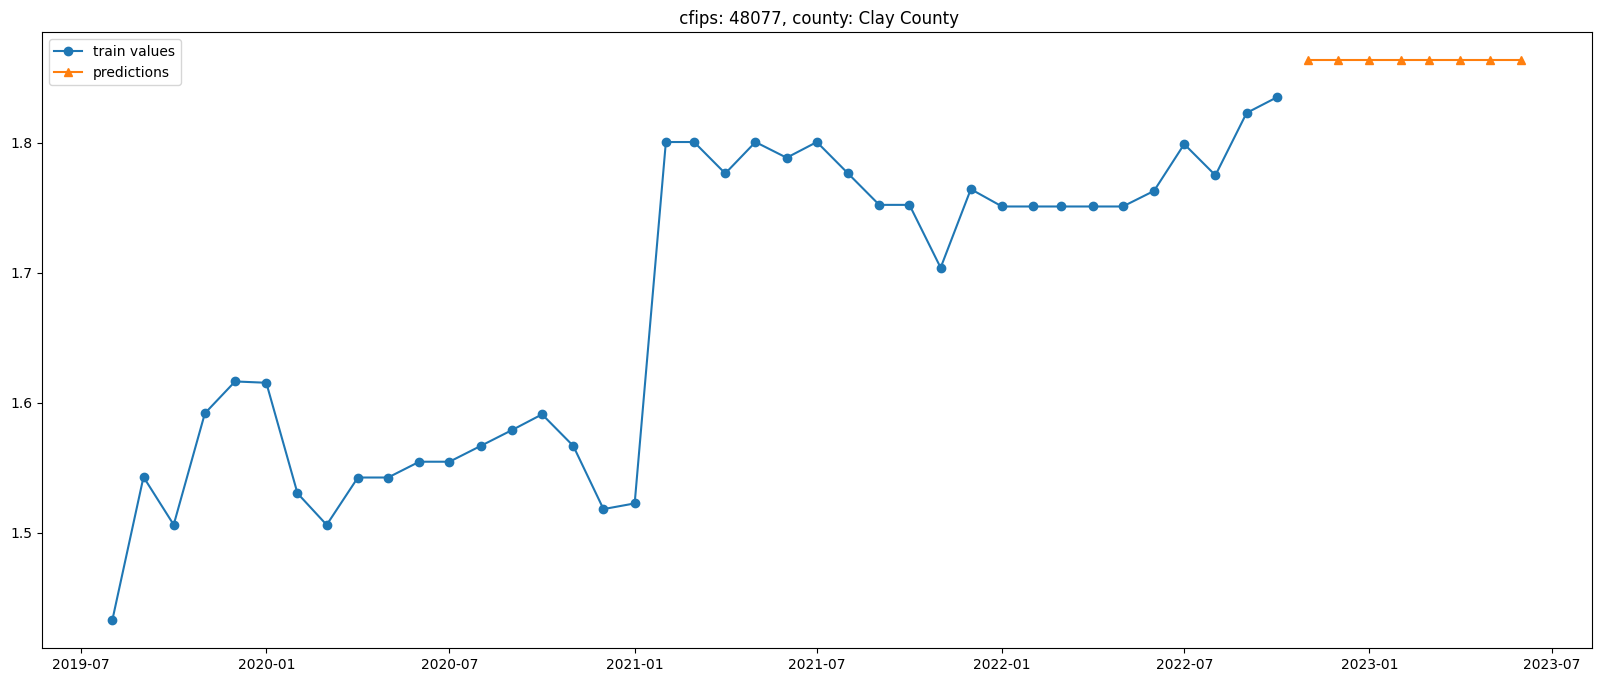

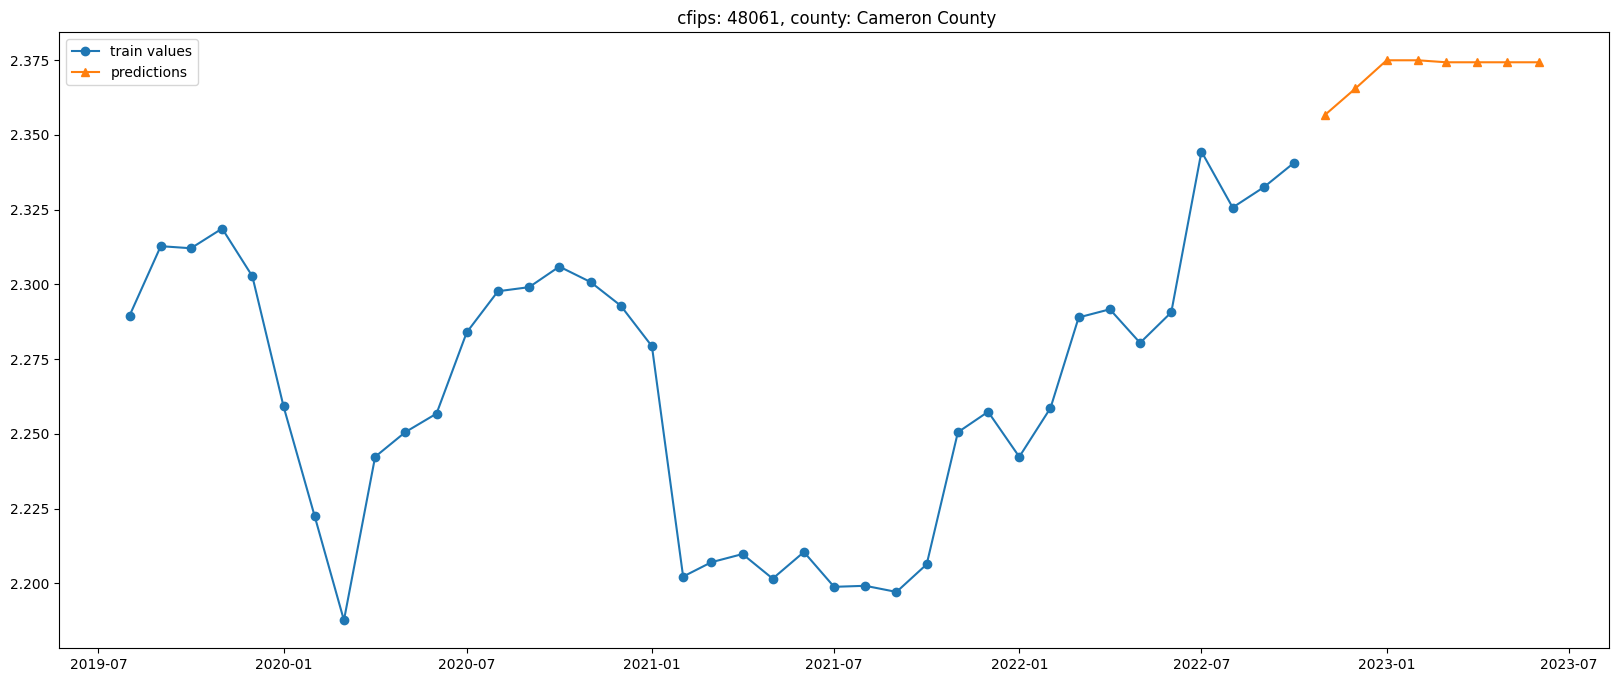

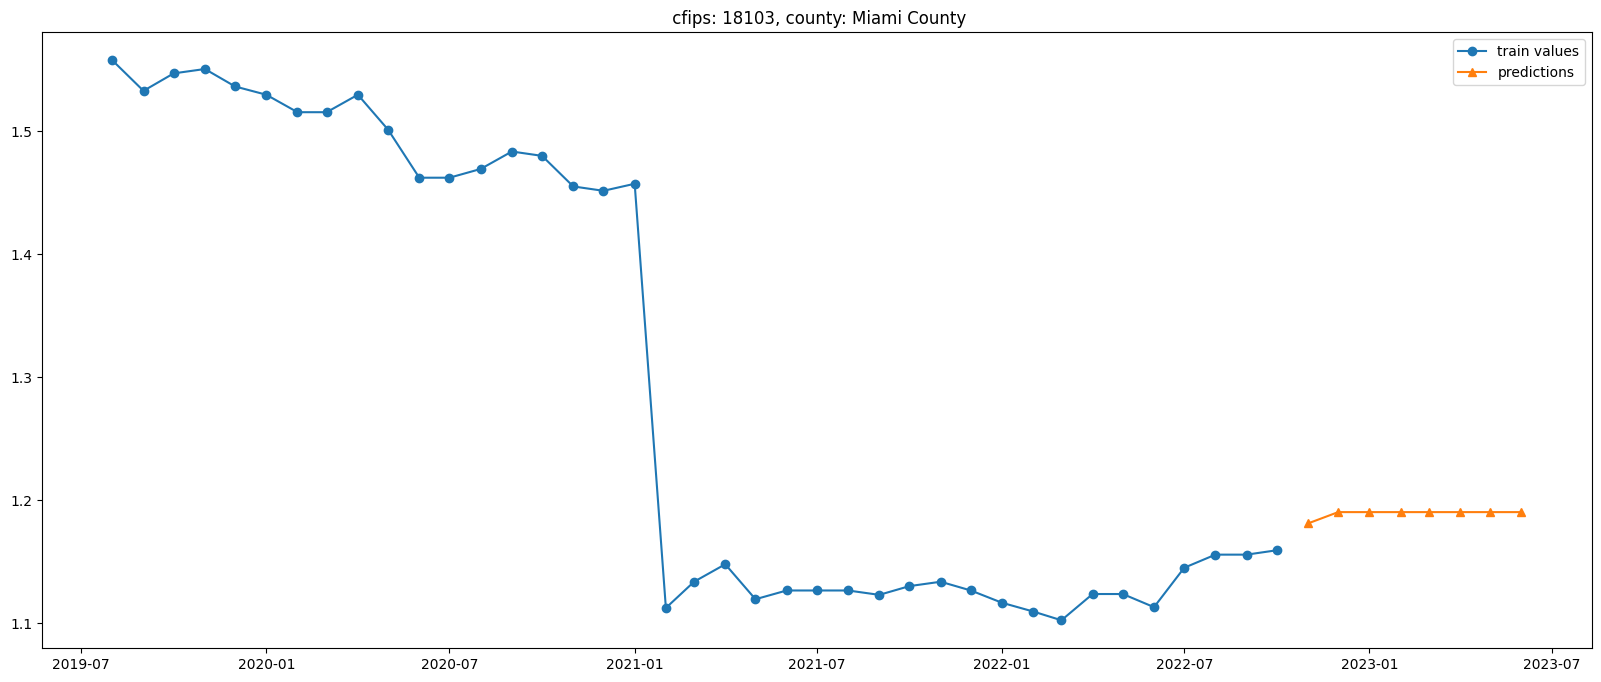

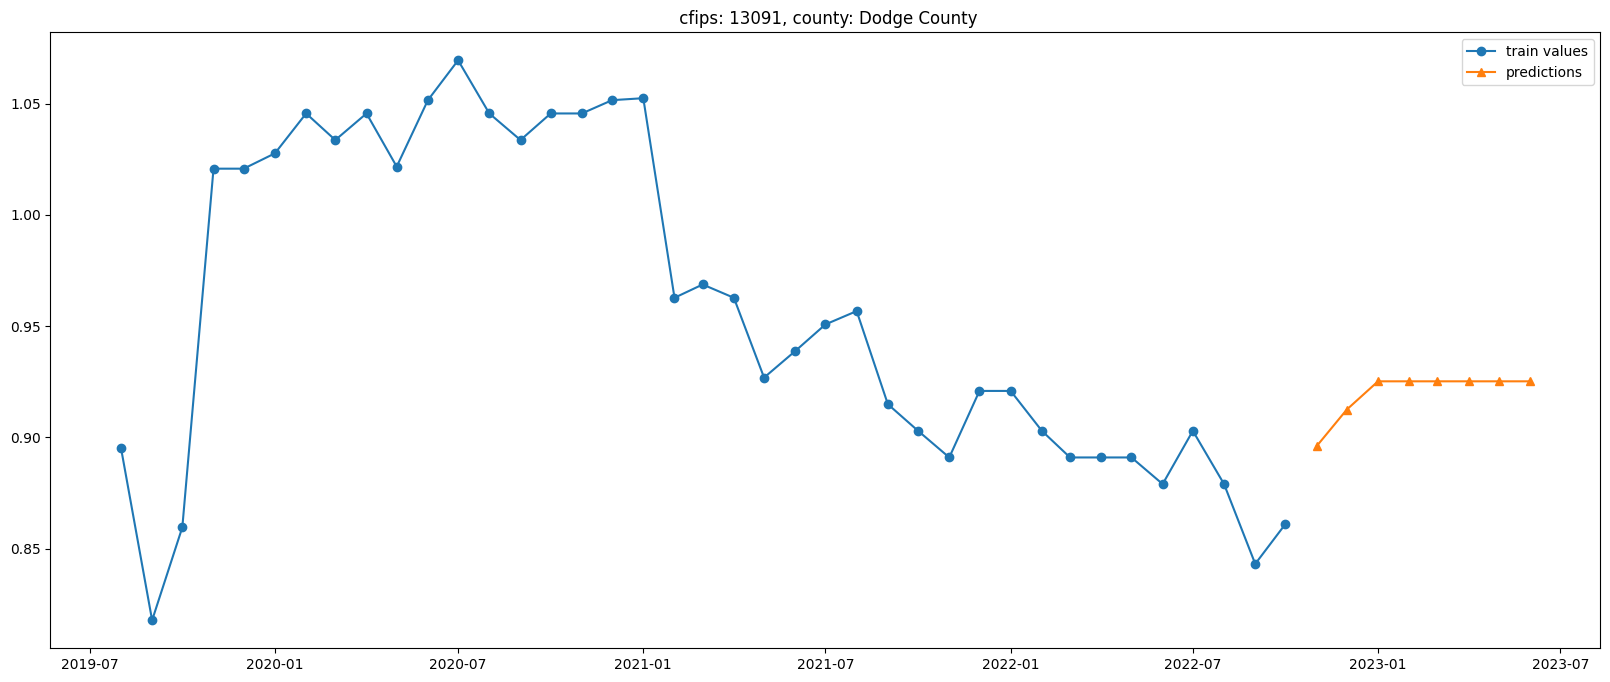

In [24]:
for i in range(10):
    c = np.random.choice(ids)
    plot_df = train_df[train_df["cfips"] == c].copy()
    test_plot = test[test["cfips"] == c].copy()
    plot_df["first_day_of_month"] = pd.to_datetime(plot_df["first_day_of_month"])
    test_plot["first_day_of_month"] = pd.to_datetime(test_plot["first_day_of_month"])
    last_target = plot_df["microbusiness_density"].values[-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(
        plot_df["first_day_of_month"],
        plot_df["microbusiness_density"],
        "-o",
        label="train values",
    )
    plt.plot(
        test_plot["first_day_of_month"],
        test_plot["microbusiness_density"],
        "-^",
        label="predictions",
    )
    plt.title(f" cfips: {c}, county: {plot_df['county'].values[0]}")
    plt.legend()
    plt.show()